In [75]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [111]:
import missingno as msno

In [76]:
figure_folder = "../Figures/EDA/"

In [77]:
transactions = load_transactions("../../Data/structured_data\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions("../../Data/structured_data\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")

In [78]:
transactions

,Unnamed: 0,ID,Datum,VerkoperVoornaam,VerkoperPatroniem,VerkoperTussen,VerkoperAchternaam,VerkoperGender,VerkoperHerkomst,VerkoperBeroep,...,KoperEtniciteit,KoperStatus,SlaafNaamNieuw,SlaafNaamOrigineel,SlaafTaalNaam,SlaafKaste,SlaafGender,SlaafLeeftijd,Opmerking,Entry-ID
0,0,554-1-1,1753-01-02,Michiel,NaN,NaN,Kruijs,m,NaN,Metselaar,...,NaN,VOC,December,NaN,NaN,NaN,m,NaN,NaN,0
1,1,554-3-1,1753-01-02,Michiel,NaN,NaN,Kruijs,m,NaN,Metselaar,...,NaN,VOC,Neptunes,NaN,NaN,NaN,m,NaN,NaN,1
2,2,554-5-1,1753-01-11,Gillis,NaN,van der,Sloot,m,NaN,Assistent,...,NaN,VOC,Dalima,NaN,NaN,NaN,v,NaN,NaN,2
3,3,554-6-1,1753-01-12,Michiel,NaN,NaN,Kruys,m,NaN,Metselaar,...,NaN,VOC,Februarij,NaN,NaN,NaN,m,NaN,NaN,3
4,4,554-8-1,1753-01-13,Jacob,NaN,NaN,Smit,m,NaN,Serg[eant],...,NaN,VOC,Fortuyn,NaN,NaN,NaN,m,NaN,"[datum deels onleesbaar, waarschijnlijk 1753; ...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,7192,1434-146-1,1793-12-09,Schoesen,NaN,NaN,Mira,o,NaN,NaN,...,Moor,Woonagtig te Kalwettij,Tanjon,Kadia,NaN,Moor,v,15,NaN,7192
7193,7193,1434-147-1,1793-12-09,Marielwittil Schoe,NaN,NaN,Miran,o,NaN,NaN,...,Moor,Woonagtig te Kalwettij,Ambar,Koroenba,Mallabaars,Parea Heiden,m,16,NaN,7193
7194,7194,1434-148-1,1793-12-09,Seidoe,NaN,NaN,Japhar,m,NaN,NaN,...,Moor,Woonagtig te Kalwettij,August,Tjatten,Mallabaars,Poelia Heiden,m,16,NaN,7194
7195,7195,1434-149-1,1793-12-09,Madatilparambil Tjangaren,NaN,NaN,Koma,o,NaN,NaN,...,Moor,Woonagtig te Kalwettij,September,Ramen,Mallabaars,Bettua Heiden,m,13,NaN,7195


In [107]:
transactions["Verkopernaam"] = transactions["VerkoperVoornaam"].fillna("") + " " + transactions["VerkoperTussen"].fillna("") + " " + transactions["VerkoperAchternaam"].fillna("")
transactions["Kopernaam"] = transactions["KoperVoornaam"].fillna("") + " " + transactions["KoperTussen"].fillna("") + " " + transactions["KoperAchternaam"].fillna("")
permissions["Bezitternaam"] = permissions["BezitterVoornaam"].fillna("") + " " + permissions["BezitterTussen"].fillna("") + " " + permissions["BezitterAchternaam"].fillna("")

In [108]:
print("Number of unique sellers: ", len(transactions["Verkopernaam"].unique()))
print("Number of unique buyers: ", len(transactions["Kopernaam"].unique()))
print("Number of unique owners: ", len(permissions["Bezitternaam"].unique()))

Number of unique sellers:  4700
Number of unique buyers:  3406
Number of unique owners:  1234


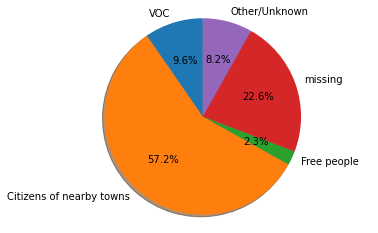

In [102]:
n_total = transactions.shape[0]
n_voc_sellers = (transactions["VerkoperStatus"] == "VOC").sum()
n_inw_sellers = transactions["VerkoperStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = transactions["VerkoperStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = transactions["KoperStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'seller_status.png', bbox_inches='tight')

[3457, 367, 935, 1626, 803]


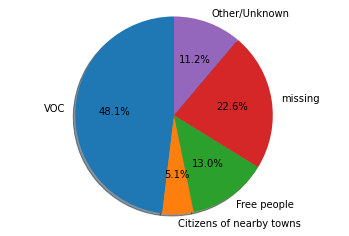

In [103]:
n_total = transactions.shape[0]
n_voc_sellers = (transactions["KoperStatus"] == "VOC").sum()
n_inw_sellers = transactions["KoperStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = transactions["KoperStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = transactions["KoperStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))
print(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'buyer_status.png', bbox_inches='tight')

In [104]:
transactions["KoperStatus"].isna().sum()

1626

[566, 10, 167, 2898, 102]


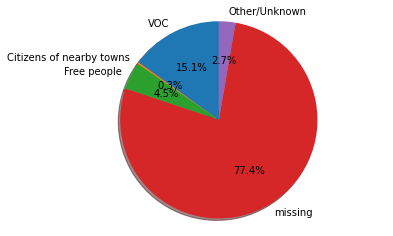

In [105]:
n_total = permissions.shape[0]
n_voc_sellers = (permissions["BezitterStatus"] == "VOC").sum()
n_inw_sellers = permissions["BezitterStatus"].str.contains('inw', case=False, regex=True).sum()
n_free_sellers = permissions["BezitterStatus"].str.contains('vrij', case=False, regex=True).sum()
n_missing_buyers = permissions["BezitterStatus"].isna().sum()


labels = 'VOC', 'Citizens of nearby towns', 'Free people', 'missing', 'Other/Unknown'
sizes = [n_voc_sellers, n_inw_sellers, n_free_sellers, n_missing_buyers]
sizes.append(n_total - sum(sizes))
print(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(figure_folder + 'owner_status.png', bbox_inches='tight')

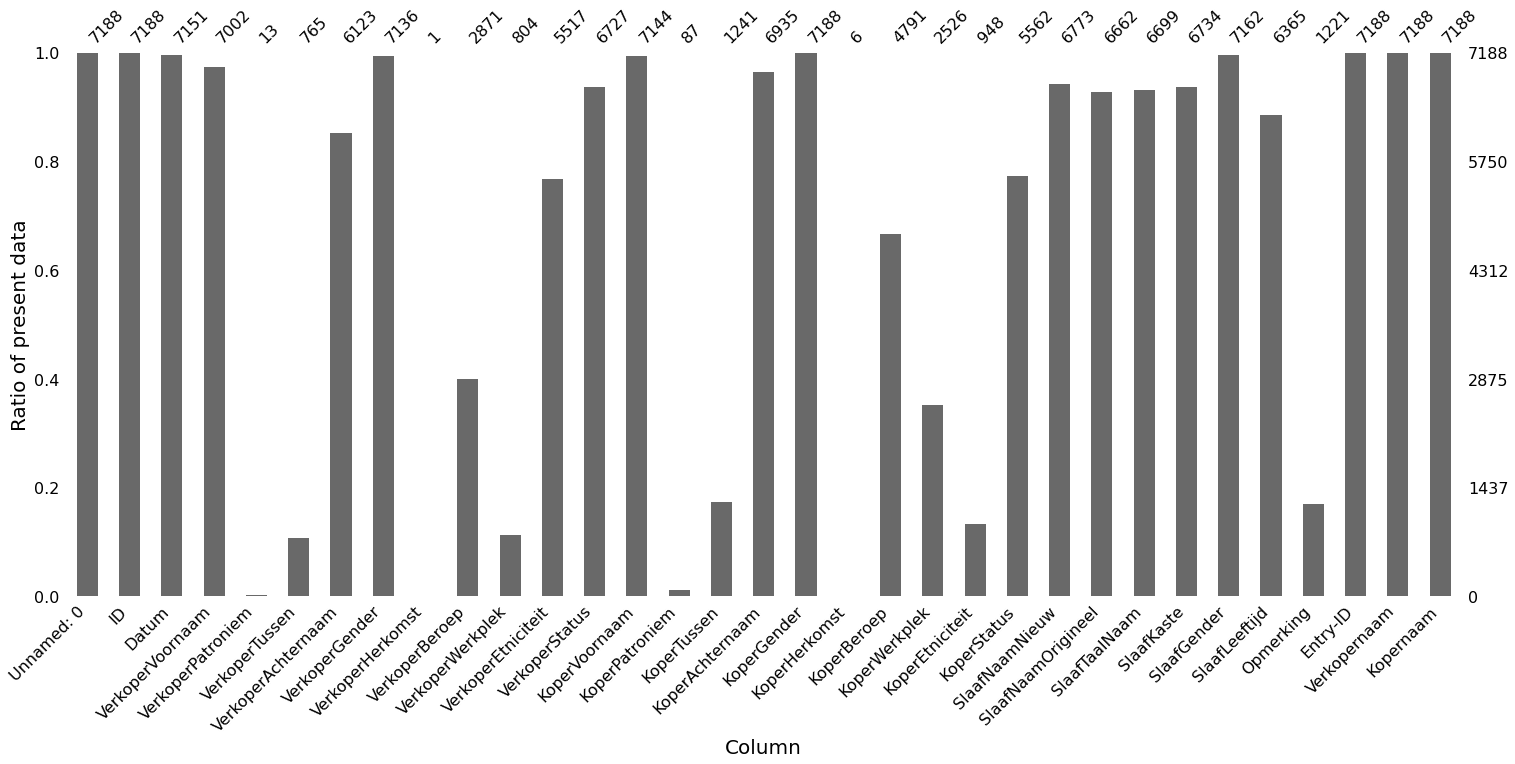

In [130]:
fontsize = 20
ax = msno.bar(transactions)
ax.set_xlabel('Column', fontsize=fontsize)
ax.set_ylabel('Ratio of present data', fontsize=fontsize)

plt.savefig(figure_folder + 'missing_transaction.png', bbox_inches='tight')

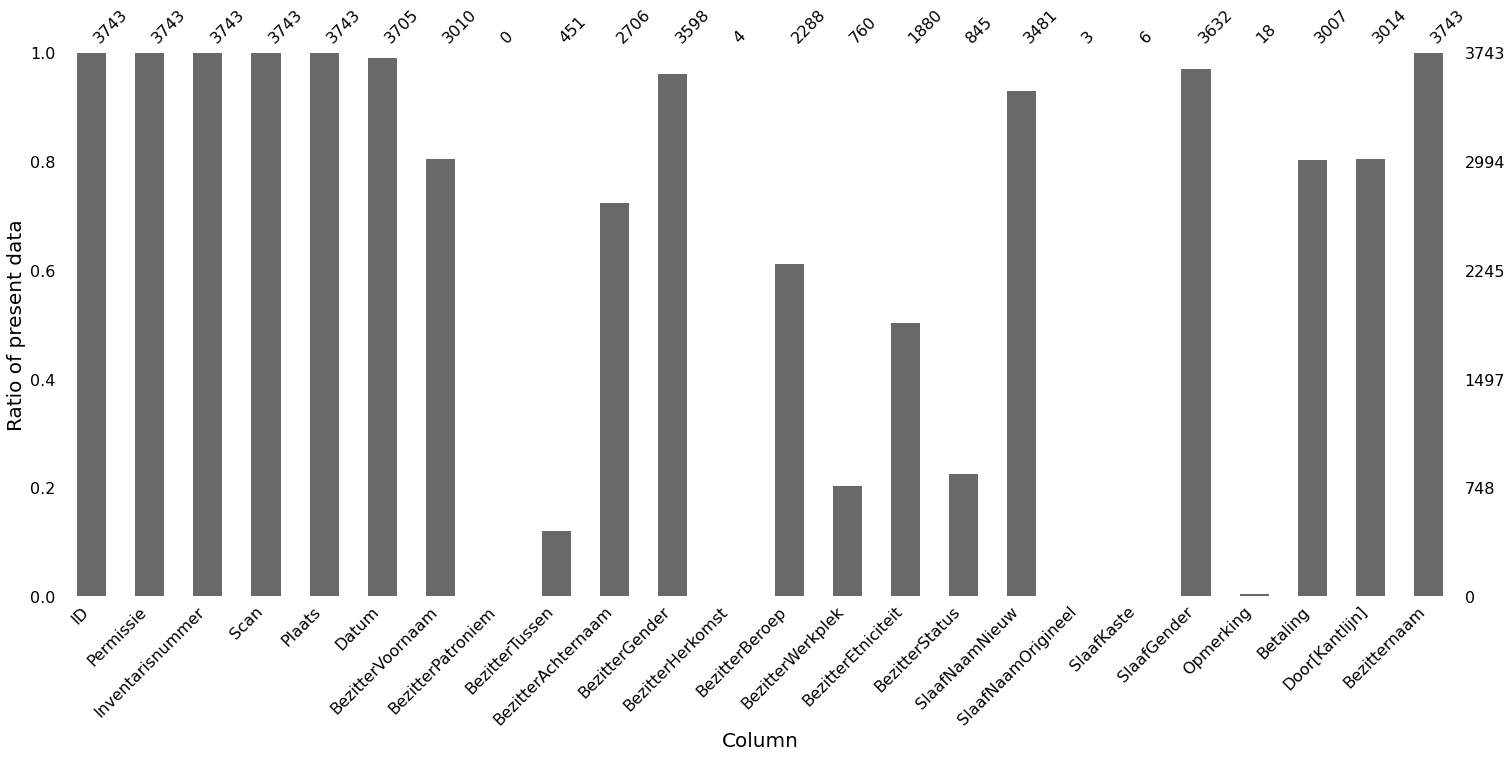

In [131]:
fontsize = 20
ax = msno.bar(permissions)
ax.set_xlabel('Column', fontsize=fontsize)
ax.set_ylabel('Ratio of present data', fontsize=fontsize)

plt.savefig(figure_folder + 'missing_permission.png', bbox_inches='tight')